<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Improving Our Linear Regression Model

_Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City)_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

plt.style.use('fivethirtyeight')

In [2]:
%matplotlib inline

In [27]:
bikes = pd.read_csv('../assets/data/bikeshare_modified.csv',
                    index_col='datetime',
                    parse_dates=True
                   )

In [4]:
bikes.head()

,season_num,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,3.28,3.0014,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,2.34,1.9982,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,2.34,1.9982,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,3.28,3.0014,75,0.0,0,1,1


## How to Select a Model

In a supervised learning paradigm, our primary goal is to make accurate predictions on new cases the model hasn't seen before. As a result, **the primary criterion we use to choose among models is performance on test data that wasn't used to train the model**.

That being said, **we are often willing to trade accuracy for simplicity**: using fewer features and simpler modeling techniques makes the model easier to maintain, easier to interpret, and faster to run.

### Evaluation Metrics for Regression Problems

There are several ways to measure the performance of a regression model.

#### Mean Squared Error

**Mean squared error (MSE)** is the average of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Notes:**

- Squaring the errors is one way to make them positive, so that both overestimates and underestimates count against the model.
- Linear regression minimizes MSE on the training set.
- It is hard to look at an MSE value and know whether it's good or bad because it is in different units than the target variable.

You can picture MSE as the average area of a square one side of which is the difference between the the actual value and the regression line:

![](../assets/images/mse.png)

#### Root Mean Squared Error

**Root mean squared error (RMSE)** is the square root of the MSE:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Notes:**

- RMSE is more helpful to a human than MSE because it is at least in the same units as the target variable. However, it's still a little hard to interpret -- it's kind of like average error, but not quite.
- Minimizing MSE also minimizes RMSE, so linear regression also minimizes RMSE on the training set.

You should probably always look at RMSE rather than MSE, because it's effectively the same thing for many purposes and is easier to grok.

#### Mean Absolute Error

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Notes:**

- MAE is simply the average magnitude of the error, so it is easier to interpret than MSE or RMSE.
- Linear regression does NOT minimize MAE on the training set.

If the units of your target variable are easy to grasp (e.g. dollars), then reporting MAE is probably a good idea.

You can picture MAE as simply the average distance between the prediction and the actual value:

![](../assets/images/mae.png)

**Exercise (3 mins.)** Calculate MAE, MSE, and RMSE for the values below.

In [5]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

- Fill in these calculations.

*Hints*: 

- Turn the lists in numpy arrays.
- There is a built-in `abs` function for absolute value.
- NumPy has a square root function `np.sqrt`.

In [6]:
# Starter code -- uncomment and fill in the commented-out lines
import math 
true = np.array(true)
# pred = 
n = len(true)

mae = sum(abs(true - pred))/n
mse =sum(abs(true-pred)**2)/n
rmse = math.sqrt(sum(abs(true-pred)**2)/n)


- Run this cell to check your answers. (It should raise an AssertionError if you made a mistake.)

In [7]:
from sklearn import metrics
np.testing.assert_almost_equal(mae, metrics.mean_absolute_error(true, pred))
np.testing.assert_almost_equal(mse, metrics.mean_squared_error(true, pred))
np.testing.assert_almost_equal(rmse, np.sqrt(metrics.mean_squared_error(true, pred)))

$\blacksquare$

#### Operational Differences Between (R)MSE and MAE

Choosing between (R)MSE and MAE has consequences beyond ease of interpretation.

In [8]:
from sklearn import metrics

true = [10, 7, 5, 5]
pred1 = [8, 6, 5, 10]  # Makes small-to-medium errors
pred2 = [10, 7, 5, 13]  # Makes one big error
print('Pred1 MAE:', metrics.mean_absolute_error(true, pred1))
print('Pred1 MSE:', metrics.mean_squared_error(true, pred1))
print()
print('Pred2 MAE:', metrics.mean_absolute_error(true, pred2))
print('Pred2 MSE:', metrics.mean_squared_error(true, pred2))

Pred1 MAE: 2.0
Pred1 MSE: 7.5

Pred2 MAE: 2.0
Pred2 MSE: 16.0


`pred1` and `pred2` have the same MAE (average error), but `pred2` has a much larger MSE. This discrepancy between MAE and MSE comes from the fact that **MSE is more sensitive to large one-off errors than MAE**. When choosing between MAE and MSE, **think about whether or not this property is appropriate for your problem**. For instance, is an error of 4 twice as bad as an error of 2 (MAE), or is it four times as bad (MSE)?

#### R-Squared and Comparing to a "Null Model"

You can use (R)MSE and MAE to compare different models, but how do you know whether any of your models are any good?

A good general strategy is to compare your model to a **null model** that just predicts the mean of the target variable every time, without using any of the features. If your model is not substantially better than the null model, then it probably is not worth using.

**R-squared** is a metric that directly addresses the question of how well your model does compared to the null model.

$$R^2=1-\frac{\mbox{Your Model MSE}}{\mbox{Null Model MSE}}$$

In statistics, the null model MSE is called "Mean Squared Total" (MST).

![](../assets/images/r_squared.png)

**Notes:**

- $R^2=0$ means that your model is no better than the null model.
- $R^2=1$ is the maximum -- it means that your model is making perfect predictions (which is suspicious).
- $R^2<0$ means that your model is worse than the null model (which can happen).
- $R^2$ is often called "percent of variance explained." I prefer **percent of variance captured** because "explained" suggests that the model gives a *causal* explanation, which is typically false.

In [9]:
# Use the sklearn .score() method to calculate test-set R-squared
# for a linear regression model with features
# ['temp_celsius', 'season_num', 'humidity_percent']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
feature_cols = ['temp_celsius', 'season_num', 'humidity_percent']
target_col = 'num_total_users'

X = bikes.loc[:,feature_cols]
y = bikes.loc[:,target_col]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123)
 
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_test,y_test)


0.24894284758836105

#### Advice for Using Regression Evaluation Metrics

- Use R-squared to compare your model to a "null model" that just guesses the mean every time. This step is often useful when you are just getting started on a regression problem.
- Use RMSE or MAE to compare models using a number that's relatively interpretable. Use MSE if an occasional large error is much worse than frequent small errors of the same total magnitude, MAE otherwise.

Regardless of what metric you use, performance on the **test set** is what matters in the end.

### Comparing Models With Train/Test Split and RMSE

In [10]:
# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols):
    target_col = 'num_total_users'
    X = df.loc[:,feature_cols]
    y = df.loc[:, target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123)
 
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)   
    y_pred = linreg.predict(X_test)
    mse = metrics.mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    return(rmse)

In [11]:
# Compare different sets of features.
print(train_test_rmse(bikes, ['temp_celsius']))
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'weather', 'humidity_percent']))
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'weather']))
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'humidity_percent']))

168.02608345551053
158.0291616183559
166.53297370241094
158.05455276955826


## Selecting Features

Blindly throwing all of your variables into a linear regression model is not a great strategy. Let's inspect our data and come up with something smarter.

We want features that are strongly correlated with the target and not with each other.

**Exercise (6 mins.)**

- Create another `LinearRegression` instance that is fit using `temp_celsius` and `atemp_celsius`, and print the coefficients.

In [12]:
feature_cols= ['temp_celsius', 'atemp_celsius']
target_col = 'num_total_users'
X = bikes.loc[:,feature_cols]
y = bikes.loc[:, target_col]
    
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123)
 
linreg = LinearRegression()
linreg.fit(X_train,y_train)   
list(zip(feature_cols,linreg.coef_))

[('temp_celsius', 6.954430305289558), ('atemp_celsius', 1.0038485426593866)]

- Create another `LinearRegression` instance that is fit using `atemp_celsius` only, and print the coefficients.

In [13]:
feature_cols= ['atemp_celsius']
target_col = 'num_total_users'
X = bikes.loc[:,feature_cols]
y = bikes.loc[:, target_col]
    
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123)
 
linreg = LinearRegression()
linreg.fit(X_train,y_train)   
list(zip(feature_cols,linreg.coef_))

[('atemp_celsius', 6.492535625032236)]

- Why is the coefficient for `atemp_celsius` so different in the two models?

Because the first model is effected by both input variables. The variables are likely correlated which accounts for why the coefficient for atemp increases when tmp is removed. 


$\blacksquare$

This case is an example of *collinearity*.

Collinearity happens when two or more features are highly correlated with each other. It causes problems:

- Coefficients become hard to interpret
- Adding a variable to the model that is collinear with another variable in the model adds complexity while contributing limited new information.
- Model fitting can become numerically unstable.

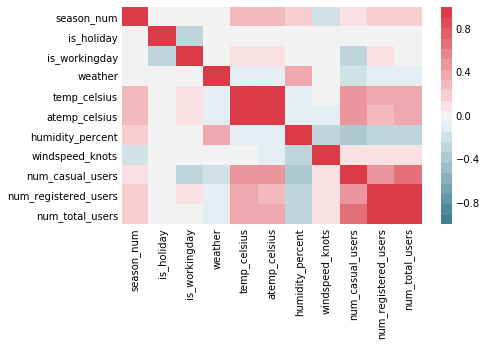

In [14]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(bikes.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(220,10,n=21),);

- `num_total_users` is of course strongly correlated with `num_casual_users` and `num_registered_users`, but those features are not usable for prediction.
- It is most positively correlated with `temp_celsius` and `atemp_celsius` among usable features, but those features are largely redundant because they are strongly correlated with one another.
- It is also moderately negatively correlated with `humidity_percent`. (Negative correlation is just as useful for prediction as positive correlation.)

In [15]:
# Let's see what happens to RMSE when we add `atemp_celsius` to a model that 
# already has `temp_celsius`
print(train_test_rmse(bikes, ['temp_celsius']))
print(train_test_rmse(bikes, ['temp_celsius','atemp_celsius']))

168.02608345551053
168.03287652254232


## Handling Categorical and Ordinal Features

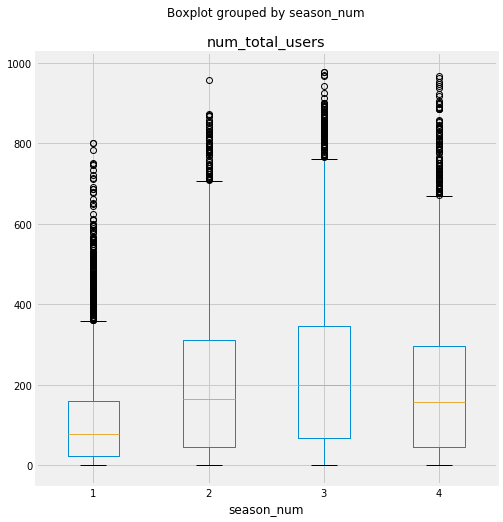

In [16]:
# Box plot of rentals, grouped by season_num.
ax = bikes.boxplot('num_total_users', by ='season_num',figsize=(8,8))

**Exercise (4 mins., in groups)**

We are representing the seasons as follows:

1: winter
2: spring
3: summer
4: fall

Suppose we fit a linear regression model for ridership against `season_num` only and get a coefficient 10, so that our model has this form:

$\mbox{num_total_users} = \beta_0 + 10 * \mbox{season_num}$.

- How do the model's predictions change from winter to spring?

- How do the model's predictions change from spring to summer?

- How do the model's predictions change from summer to fall?

- Why might this consequence of using `season_num` in a linear regression model be a problem?

$\blacksquare$

Here's a better representation:

- `is_spring`: 1 in spring, 0 otherwise
- `is_summer`: 1 in summer, 0 otherwise
- `is_fall`: 1 in fall, 0 otherwise

Instead of having one variable with 4 levels, we have 3 binary variables.

We can now create a linear regression model that has three "degrees of freedom" to capture the impact of the season, instead of just one:

$\mbox{num_total_users} = \beta_0 + \beta_1 * \mbox{is_spring} + \beta_2 * \mbox{is_summer} + \beta_3 * \mbox{is_fall}$.

This process is called "dummy coding."

**Exercise (5 mins., in groups)**

Suppose we fit a linear regression model for ridership against our dummy variables for season only and get the following coefficients:

$\mbox{num_total_users} = \beta_0 + 10 * \mbox{is_spring} + 25 * \mbox{is_summer} + 5 * \mbox{is_fall}$

- How do the model's predictions change for spring relative to winter?

- How do the model's predictions change for summer relative to spring?

- How do the model's predictions change for fall relative to summer?

- Why is `is_winter` unnecessary?

- In fact, including `is_winter` would be harmful. Why?

- Could you use `is_winter`, `is_spring`, and `is_summer` instead? Why or why not? Is there any reason to prefer one set of dummy variables over another?

$\blacksquare$

In [18]:
# Take every 1000 rows for the moment to make it easier to see what's going on
bikes_sample = bikes.sample(1000)
bikes_sample.head()

,season_num,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users
datetime,,,,,,,,,,,
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0000,3,10,13
2012-02-12 06:00:00,1,0,0,1,-3.30,-10.9972,49,0.3881,0,2,2
2012-11-05 05:00:00,4,0,1,2,6.10,1.9982,52,0.3284,1,38,39
2012-11-15 18:00:00,4,0,1,2,8.92,7.0010,56,0.1940,10,563,573
2012-01-08 09:00:00,1,0,0,1,7.04,5.9978,53,0.1343,23,102,125


In [21]:
# Now dummy-code `season_num`
dummies = pd.get_dummies(bikes_sample, columns=['season_num'])
dummies.head()

,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users,season_num_2,season_num_3,season_num_4
datetime,,,,,,,,,,,,,
2011-01-01 03:00:00,0,0,1,3.28,3.0014,75,0.0000,3,10,13,0,0,0
2012-02-12 06:00:00,0,0,1,-3.30,-10.9972,49,0.3881,0,2,2,0,0,0
2012-11-05 05:00:00,0,1,2,6.10,1.9982,52,0.3284,1,38,39,0,0,1
2012-11-15 18:00:00,0,1,2,8.92,7.0010,56,0.1940,10,563,573,0,0,1
2012-01-08 09:00:00,0,0,1,7.04,5.9978,53,0.1343,23,102,125,0,0,0


In [22]:
# Drop a redundant column
dummies = dummies.drop('season_num_1', axis='columns')
dummies.head()

,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users,season_num_2,season_num_3,season_num_4
datetime,,,,,,,,,,,,,
2011-01-01 03:00:00,0,0,1,3.28,3.0014,75,0.0000,3,10,13,0,0,0
2012-02-12 06:00:00,0,0,1,-3.30,-10.9972,49,0.3881,0,2,2,0,0,0
2012-11-05 05:00:00,0,1,2,6.10,1.9982,52,0.3284,1,38,39,0,0,1
2012-11-15 18:00:00,0,1,2,8.92,7.0010,56,0.1940,10,563,573,0,0,1
2012-01-08 09:00:00,0,0,1,7.04,5.9978,53,0.1343,23,102,125,0,0,0


In [23]:
# Or do it in one step:
dummies2 = pd.get_dummies(bikes_sample, columns = ['weather'], drop_first = True)
dummies2.head()

,season_num,is_holiday,is_workingday,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users,weather_2,weather_3
datetime,,,,,,,,,,,,
2011-01-01 03:00:00,1,0,0,3.28,3.0014,75,0.0000,3,10,13,0,0
2012-02-12 06:00:00,1,0,0,-3.30,-10.9972,49,0.3881,0,2,2,0,0
2012-11-05 05:00:00,4,0,1,6.10,1.9982,52,0.3284,1,38,39,1,0
2012-11-15 18:00:00,4,0,1,8.92,7.0010,56,0.1940,10,563,573,1,0
2012-01-08 09:00:00,1,0,0,7.04,5.9978,53,0.1343,23,102,125,0,0


Unlike `season`, our variable `weather` is at least ordinal:

1: Clear, 2: Mist, 3: Light Rain or Snow 4: Heavy Rain or Snow

However, there's no reason to assume that the difference between Clear and Mist has the same impact on ridership as the difference between Mist and List Rain/Snow or the difference between Light Rain/Snow and Heavy Rain/Snow. Here too our model can benefit from the additional degrees of freedom that dummy coding provides.

**Exercise (3 mins.)**

Use the full data set `bikes` for these exercises, rather than the reduced `bikes_sample_seasons`.

- Use pandas to create dummy columns for `weather`, and drop the column that you want to use as a baseline.

In [24]:
dumm = pd.get_dummies(bikes, columns = ['season_num'], drop_first = True)

- How many dummy variables do you need for a categorical feature with $k$ possible values? Why?

k-1, because the first is used as a "baseline"

$\blacksquare$

Let's rerun the linear regression with dummy variables included.

In [31]:
# Include dummy variables for season_num in the model.
# Include dummy variables for season_num in the model.
dummies = pd.get_dummies(bikes, columns=['season_num'], drop_first=True)

#feature_cols = ['temp_celsius', 'humidity_percent', 'season_num_2', 'season_num_3', 'season_num_4']
feature_cols = ['humidity_percent', 'season_num_2', 'season_num_3', 'season_num_4']
target_col = 'num_total_users'
X = dummies.loc[:, feature_cols]
y = dummies.loc[:, target_col]

lr = LinearRegression()
lr.fit(X, y)

list(zip(feature_cols, lr.coef_))


[('humidity_percent', -3.3956147840582718),
 ('season_num_2', 112.71277016075393),
 ('season_num_3', 142.44448631844278),
 ('season_num_4', 116.87061945089587)]

**Exercise (6 mins.)**

- What does the coefficient for summer mean?

Summer is moderately negatively correlated to ridership.

- Huh? How can we get a coefficient of -46.37 in summer, the most popular season?

- Would our model's predictions change if we dropped a different dummy column for season?

No

- Use train_test_rmse to compare the performance of a model with `temp_celsius`, `season_num`, and `humidity_percent` to one that replaces `season_num` with its dummies.

In [30]:
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'humidity_percent']))
print(train_test_rmse(bikes, ['temp_celsius', 'season_num_2', 'season_num_3', 'season_num_4', 'humidity_percent']))

158.05455276955826


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Summary

- Test a model against data that wasn't used to train it.
- For a regression model, use a metric such as MAE, (R)MSE, or R-squared.
- Experiment with adding and dropping features.
- Favor features that are correlated with the target and uncorrelated with other features.
- Experiment with different ways to represent features, such as dummy-coding for categorical and ordinal variables.

## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Interpretable -- sort of.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response. (But you can model nonlinear relationships with your *original* features by including *transformations* of those features, e.g. the square of one of those features.)
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.
- Easy to overinterpret.